**19/12/2021**
<br>
Bruno Mazzilli González

> # Gradient Boosted Trees

El XGboost (Extra Gradient boosting) es un modelo que se implementa en minería de datos para clasificar o pronosticar sobre una variable objetivo (y). El XGboost combina un conjunto de clasificadores debiles (arboles de decisiones simples que por si solos no tienen buen rendimiento) usando pesos para cada clasificador. El modelo se adapta utilizando clasificadores débiles ya creados para ajustar los pesos de instancias de la variable target clasificadas erróneamente en el siguiente clasificador debil creado. De este modo el modelo aprende en serie de los clasificadores debiles. Los claficafores debiles también tienen un parametro que determina su peso en la decision final del conjunto.

El modelo potencia los resultados gracias al procesamiento secuencial de los datos con una función de pérdida o coste, la cual, minimiza el error iteración tras iteración.

Así pues, indicamos las principales ventajas de utilizar este método:

Trabaja sobre grandes bases de datos con múltiples variables, tanto categóricas como numéricas y es un modelo que no suele hacer overfitting. 

No obstante presenta la siguiente desventaja principal:

Utiliza grandes cantidades de memoria RAM, por lo que, es recomendable procesar el algoritmo determinando previamente mediante una validación cruzada, las variables que más aportan información a la estructuración del modelo.

### Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt # plots
import seaborn as sns # plots
import pickle

from sklearn.metrics import classification_report, confusion_matrix 

from sklearn import datasets, metrics, model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

### Importamos datos

In [2]:
X_train = pd.read_parquet('data/x_train.parquet')

X_test = pd.read_parquet('data/x_test.parquet')
X_test.reset_index(drop=True, inplace=True)

Y_train = pd.read_parquet('data/y_train.parquet')

Y_test = pd.read_parquet('data/y_test.parquet')
Y_test.reset_index(drop=True, inplace=True)

### Modelo XGBOOST

In [3]:
%%time

# función del modelo
XGBOOST = xgb.XGBClassifier(n_estimators = 500,          # número de árboles 
                           booster='gbtree',            # tipo de booster - gradient boosting
                           n_jobs = -1,                 # número de prodesadores
                           objective='binary:logistic') # indicamos que se trata de una variable binaria a predecir


# Entrenamiento del modelo con dataset TRAIN
XGBOOST.fit(X_train, np.ravel(Y_train))

# Predicción del modelo con data set TEST
Y_pred_boost = XGBOOST.predict(X_test)

[21:06:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 7h 3min 57s, sys: 1h 59min 30s, total: 9h 3min 28s
Wall time: 3h 4min 52s


<br>

### Matriz de Confusión

In [4]:
def conf_matrix(Y_test, Y_pred): # va a comparar los resultados de las predicciones de la variable target vs la real del testset
    cnf_matrix_tra = confusion_matrix(Y_test, Y_pred)
    conf_plot = sns.heatmap(cnf_matrix_tra, annot=True, cmap='Blues', fmt='g')
    bottom, top = conf_plot.get_ylim()
    conf_plot.set_ylim(bottom + 0.5, top - 0.5)
    conf_plot.set_title("Confusion matrix, without normalization")
    conf_plot.set_ylabel('True Label')
    conf_plot.set_xlabel('Predicted Label');

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1474318
           1       0.60      0.15      0.24     24548

    accuracy                           0.98   1498866
   macro avg       0.79      0.57      0.61   1498866
weighted avg       0.98      0.98      0.98   1498866



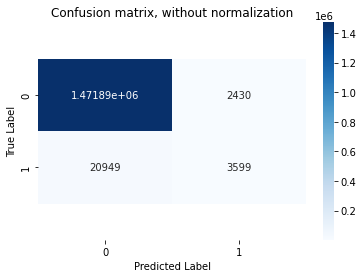

In [5]:
# calculamos la matriz de confusión del modelo:
conf_matrix(Y_test, Y_pred_boost)                 # para la matriz de confusión usamos los datos de test
print(classification_report(Y_test,Y_pred_boost)) # comparamos los restulados de la prediccion y los dados por el dataset Y_test

### Matriz Normalizada

In [6]:
def conf_matrix_norm(Y_test, Y_pred): # va a comparar los resultados de las predicciones de la variable target vs la real del testset
    cnf_matrix_tra = confusion_matrix(Y_test, Y_pred,  normalize='true')
    conf_plot = sns.heatmap(cnf_matrix_tra, annot=True, cmap='Blues', fmt='g')
    bottom, top = conf_plot.get_ylim()
    conf_plot.set_ylim(bottom + 0.5, top - 0.5)
    conf_plot.set_title("Confusion matrix, with normalization")
    conf_plot.set_ylabel('True Label')
    conf_plot.set_xlabel('Predicted Label');

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1474318
           1       0.60      0.15      0.24     24548

    accuracy                           0.98   1498866
   macro avg       0.79      0.57      0.61   1498866
weighted avg       0.98      0.98      0.98   1498866



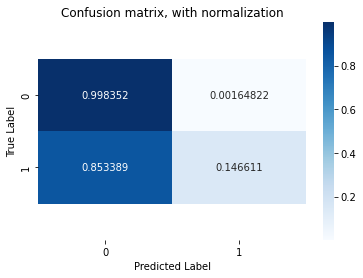

In [7]:
conf_matrix_norm(Y_test, Y_pred_boost)
print(classification_report(Y_test, Y_pred_boost))

### Curva ROC:

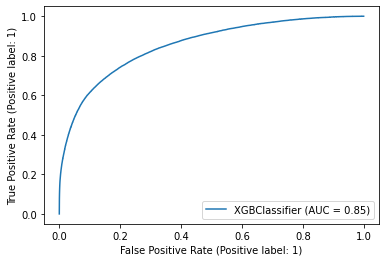

XGBOOST score train:  0.9821363353326037
XGBOOST score:  0.9844022080693003


In [9]:
metrics.plot_roc_curve(XGBOOST, X_test, Y_test)                 # CURVA ROC
plt.show() 
print("XGBOOST score train: ", XGBOOST.score(X_train, Y_train)) # score_train
print("XGBOOST score: ", XGBOOST.score(X_test, Y_test))         # score_test

### Gain Curve:

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

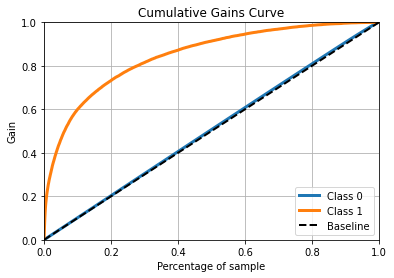

In [10]:
# Deriving Class probabilities
predicted_probabilities = XGBOOST.predict_proba(X_test)
# Creating the plot
skplt.metrics.plot_cumulative_gain(Y_test, predicted_probabilities)

### Feature importance

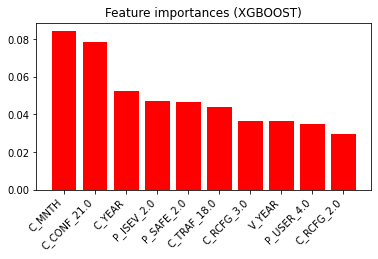

In [11]:
coefs = np.abs(XGBOOST.feature_importances_)
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (XGBOOST)")
plt.bar(range(10), coefs[indices[:10]],
       color="r", align="center")
plt.xticks(range(10), X_train.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

#### Guardamos el modelo

In [12]:
# función para guardar el modelo
def save_models(filename, model):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [14]:
save_models('models/xg_boost_model.pkl', XGBOOST ) 